In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

import time
import shutil

# from torchsample.modules import ModuleTrainer
# import torchsample

In [2]:
base_path = "data"
train_path = base_path + "/train"
valid_path = base_path + "/valid"

In [3]:
mean_val, std_val = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_tmft =  transforms.Compose([
    transforms.RandomRotation(30),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_val,std_val)
])

valid_tmft =  transforms.Compose([
    transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean_val,std_val)
])

# TODO: Load the datasets with ImageFolder
trainset = torchvision.datasets.ImageFolder(train_path, transform=train_tmft)
validset = torchvision.datasets.ImageFolder(valid_path, transform=valid_tmft)


BSIZE = 20
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BSIZE, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BSIZE, shuffle=True, num_workers=0)

CLAZZ = len(trainset.classes)
CLAZZ

7

In [4]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


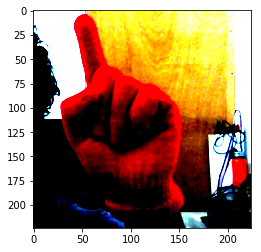

In [5]:
img = images[2].permute(1,2,0).numpy()
# img = np.clip(img, 0, 1)
plt.imshow(img, cmap='gray')

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [7]:
def hand_squeezenet(pretrained=True, n_class=1000):
    net=torchvision.models.squeezenet1_1(pretrained=pretrained)
    net.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(512, n_class, kernel_size=1, stride=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=13, stride=1, padding=0)
        )
    net.forward = lambda x: net.classifier(net.features(x)).view(x.size(0), n_class)
    return net



# model=hand_squeezenet(pretrained=True, n_class=7)
# x=torch.randn(2,3,224,224)
# model(x)

In [8]:
from torchtools.trainer import Trainer
from torchtools.meters import LossMeter, AccuracyMeter
from torchtools.callbacks import (StepLR, ReduceLROnPlateau, TensorBoardLogger, CSVLogger)


model = hand_squeezenet(pretrained=True, n_class=7)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.CrossEntropyLoss()

trainer = Trainer(model, train_loader, criterion, optimizer, valid_loader,device='cuda:0')


loss = LossMeter('loss')
val_loss = LossMeter('val_loss')
acc = AccuracyMeter('acc')
val_acc = AccuracyMeter('val_acc')
scheduler = StepLR(optimizer, 1, gamma=0.95)
reduce_lr = ReduceLROnPlateau(optimizer, 'val_loss', factor=0.3, patience=3)
logger = TensorBoardLogger()
csv_logger = CSVLogger(keys=['epochs', 'loss', 'acc', 'val_loss', 'val_acc'])

trainer.register_hooks([loss, val_loss, acc, val_acc, scheduler, reduce_lr, logger, csv_logger])

output = trainer.train(10)
# import torchsample

/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
Epoch 1:  29%|██▊       | 8/28 [00:01<00:02,  7.48 batches/s, iters=37, loss=0.792]


Epoch 2:  71%|███████▏  | 20/28 [00:02<00:01,  7.47 batches/s, iters=76, loss=0.452]


Validate:  43%|████▎     | 3/7 [00:00<00:00,  7.37 batches/s, loss=0.391]


Epoch 5:  21%|██▏       | 6/28 [00:00<00:02,  7.54 batches/s, iters=147, loss=0.0186]


Epoch 6:  61%|██████    | 17/28 [00:02<00:01,  7.49 batches/s, iters=185, loss=0.115]


Epoch 7:  96%|█████████▋| 27/28 [00:03<00:00,  7.53 batches/s, iters=223, loss=0.192]


Epoch 9:   7%|▋         | 2/28 [00:00<00:03,  7.51 batches/s, iters=254, loss=0.0413]


Train: 100%|██████████| 10/10 [00:47<00:00,  4.71s/epoch]s/s, loss=0.0027]


In [9]:
output.keys()

dict_keys(['model', 'arch', 'max_epoch', 'epochs', 'iters', 'optimizer', 'mode', 'meters', 'input', 'target', 'loss', 'output'])

In [29]:
acc=output['meters']['acc']
val_acc = output['meters']['val_acc']
train_accuracy=acc.correct_cnt /acc.total_cnt*100
valid_accuracy=val_acc.correct_cnt /val_acc.total_cnt*100
print(train_accuracy,valid_accuracy)

100.0 100.0


In [26]:
output['meters']

{'loss': <torchtools.meters.lossmeter.LossMeter at 0x7f527b6bbac8>,
 'val_loss': <torchtools.meters.lossmeter.LossMeter at 0x7f527b6bb940>,
 'acc': <torchtools.meters.accmeter.AccuracyMeter at 0x7f527b6bba90>,
 'val_acc': <torchtools.meters.accmeter.AccuracyMeter at 0x7f527b6bb5f8>}

In [34]:
print(1-output['meters']['loss'].mean, 1-output['meters']['val_loss'].mean)

0.9878468530649636 0.993177250476687
